Homework Group A
## Osama Al Kamel / Mtr Num: 3141575
## Joshua Oldridge / Mtr Num: 3140770
---

# Segmentation - Mini Project

## Introduction

Now it´s your turn to put it all together and train a segmentation model on a new dataset. The dataset is called "Freiburg Forest Dataset" and it contains images of forest scenes (See dataset README). The data set is located under `/data/Freiburg_Forest_Dataset`. The goal is to segment the classes "Void", "Road", "Grass", "Vegetation", "Tree", "Sky" and "Obstacle". The special thing about that dataset is that it contains multispectral and multimodal images (RGB, NIR, Depth Map etc.). <br>
Feel free to follow the CRISP-DM framework to structure your work. <br>
Overall you should at least cover the following topics:
- **Data Understanding and Data Preparation:** <br>
Build a PyToch Dataset to read in the data and analyze the dataset by plotting some samples and the class distribution. You can start by using only the RGB images and the corresponding masks.
- **Training:** <br>
Use the simplified U-Net from the lecture as a starting point and train the model on the dataset
- **Evaluation:** <br>
Evaluate the model on the test set using the accuracy and mean IoU and visualize some predictions

From here you can go further and try different things:
- **Use more modalities:** <br>
Change the dataset to use different modalities and train/evaluate the model on them (e.g. the Depth Maps)
- **Use more advanced architectures:** <br>
Try more advanced architectures by using the [Pytorch Segmentation Models Package](https://github.com/qubvel/segmentation_models.pytorch)

Use this notebook as a starting point and make sure to explain your steps and discuss your results. The goal is not to get the best possible results but to create a well structured data science story. But of course, if you get good results, that´s great! <br>
Feel free to reuse code from the lecture notebooks if you find it useful. <br>

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from PIL import Image
import numpy as np
import random
from matplotlib import pyplot as plt
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import os
import time
import cv2
print(torch.__version__)
#check if cuda is available
cuda_available = torch.cuda.is_available()
print(f"cuda available: {cuda_available}")
use_cuda = cuda_available

# set random seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# helper function to count number of parameters in a model
def count_parameters(model):
    params =  sum(p.numel() for p in model.parameters() if p.requires_grad)
    m_params = params / 1e6
    print(f"Model has {m_params:.2f}M parameters")


2.2.2+cpu
cuda available: False


# Data Preperation

We define the color codes and ids for the classes as written in the README.txt file

In [3]:
freiburg_color_code = {
    "Road":(170, 170, 170),
    "Grass":(0,255,0),
    "Vegetation":(102,102,51),
    "Tree":(0,60,0),
    "Sky":(0,120,255),
    "Obstacle":(0,0,0)
}

freiburg_ids_to_class = {
    0 : "Void",
    1 : "Road",
    2 : "Grass",
    3 : "Vegetation",
    4 : "Tree",
    5 : "Sky",
    6 : "Obstacle"
}

freiburg_class_to_ids = {
    "Void" : 0 ,
    "Road" : 1,
    "Grass" : 2,
    "Vegetation" : 3,
    "Tree" : 4,
    "Sky" : 5 ,
    "Obstacle" : 6
}

def colorcode_segmentation(np_mask, color_codes, class_indices):
    """colorizes the segmentation mask using the carla color codes"""
    height, width = np_mask.shape
    rgb_mask = np.zeros((height, width, 3), dtype=int)
    
    for i in np.unique(np_mask):
        rgb_mask[np_mask == i] = color_codes[class_indices[i]]
    return rgb_mask

In [4]:
class FreiburgDataset(Dataset):
    def __init__(self, path, image_transform=None, label_transform=None, is_train=True, limit=None, img_type="rgb"):
        self.path = path
        self.limit = limit
        self.is_train = is_train
        self.image_transform = image_transform
        self.label_transform = label_transform
        self.img_type = img_type
        # list of image, segmentation mask tuples
        self.files = self._get_files()
        self.data = []
        for image, mask in tqdm(self.files):
            self.data.append(self._process(image, mask))
            
    
    def _get_files(self):
        # Get all the image files in the directory
        folder = 'train' if self.is_train else 'test'
        image_path = os.path.join(self.path, folder, self.img_type)
        data_files = []
        for root, _, files in os.walk(image_path):
            for i, file in enumerate(files):
                if(self.img_type == "rgb"):
                    if file.endswith('.jpg'):
                        image_file = os.path.join(root, file)
                        segmentation_mask = image_file.replace(self.img_type, 'GT_color').replace('.jpg', '.png')
                    
                        data_files.append((image_file, segmentation_mask))
                        if self.limit and i >= self.limit:
                            break
                elif(self.img_type == "depth_color"):
                    if file.endswith('.jpg'):
                        image_file = os.path.join(root, file)
                        segmentation_mask = image_file.replace(self.img_type, 'GT_color').replace('.jpg', '.png')
                    
                        data_files.append((image_file, segmentation_mask))
                        if self.limit and i >= self.limit:
                            break
                    
        return data_files
    
    def _process(self, image, mask):
        image = Image.open(image)
        mask = Image.open(mask)
        if self.image_transform:
            image = self.image_transform(image)
        if self.label_transform:
            mask = self.label_transform(mask)
        return image, mask

    def __len__(self):
       return len(self.files)
    
    def __getitem__(self, idx):
        return self.data[idx]   
    

In [5]:
SHAPE = (128, 128)
# image transform to transform the image to tensor, resize and normalize
image_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# for transforming the mask to a tensor with the class labels we will create a custom transform
class MaskToTensor(object):
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.mask_values = np.array([0, 1, 2, 3, 4, 5, 6])

    def __call__(self, mask):
        # Convert PIL Image to numpy array
        segmentation_mask = np.zeros((np.array(mask).shape[0], np.array(mask).shape[1]))

        
        for freiburg_class in freiburg_color_code:
            cmap = np.all(np.array(mask) == freiburg_color_code[freiburg_class], axis=-1)
            
            segmentation_mask[cmap] = freiburg_class_to_ids[freiburg_class]


        
        # Initialize tensor of zeros with the desired shape
        one_hot_mask = torch.zeros((segmentation_mask.shape[0], segmentation_mask.shape[1]))
        
        # Iterate over each unique value in the segmentation mask
        for i, value in enumerate(self.mask_values):
            
            # Create a binary mask where the value is equal to the unique value
            binary_mask = (segmentation_mask == value)

            # Assign this binary mask to the corresponding index in the tensor
            one_hot_mask[binary_mask] = i
        return one_hot_mask.to(torch.long)

# label transform to transform the label to tensor and resize
label_transform = transforms.Compose([
    transforms.Resize(SHAPE, interpolation=InterpolationMode.NEAREST_EXACT),
    MaskToTensor(16)
])


# test our transformation
image = Image.open("data/Freiburg_Forest_Dataset/train/GT_color/b10-495.png")
mask = Image.open("data/Freiburg_Forest_Dataset/train/GT_color/b10-495.png")


mask = label_transform(mask)

# for testing the output mask
cv2.imwrite("pog.png",np.array(mask) * 20)

print(f"Mask shape: {mask.shape}, unique values: {torch.unique(mask)}, dtype: {mask.dtype}")
image = image_transform(image)
print(f"Image shape: {image.shape}, min: {image.min()}, max: {image.max()}, mean: {image.mean()}, std: {image.std()}, dtype: {image.dtype}")



Mask shape: torch.Size([128, 128]), unique values: tensor([1, 2, 3, 4, 5, 6]), dtype: torch.int64
Image shape: torch.Size([3, 128, 128]), min: -2.1179039478302, max: 2.640000104904175, mean: -0.21046793460845947, std: 1.8289105892181396, dtype: torch.float32


We have 5 classes found in the image, one thing that is weird about the data set is that in the README.txt, there are 6 classes defined, but there is a duplicate class, both "Vegetation" and "Tree" have the id of 3 but diffrent color coding, so i changed the id value of "Tree" to 4 when i defined the class ids

In [6]:
BATCH_SIZE = 12
# create the dataset
train_dataset = FreiburgDataset('data/Freiburg_Forest_Dataset', image_transform, label_transform, is_train=True, limit=None)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = FreiburgDataset('data/Freiburg_Forest_Dataset', image_transform, label_transform, is_train=False, limit=None)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 136/136 [00:04<00:00, 30.68it/s]


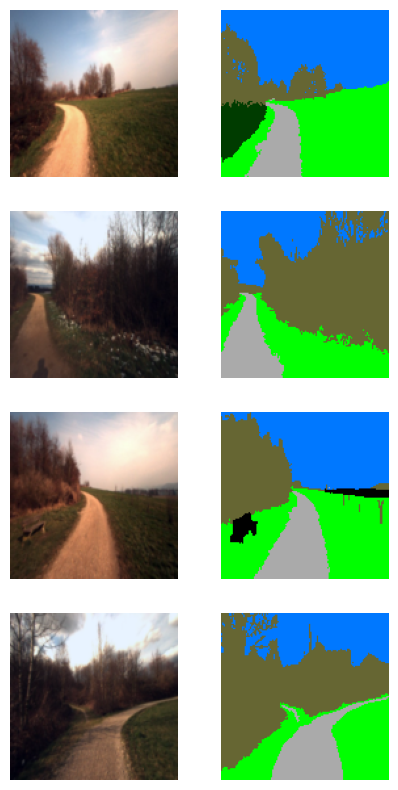

In [7]:
def show_img(image):
    min_img = image.min()
    max_img = image.max()
    showimg = ((image-min_img)/(max_img-min_img)).permute(1, 2, 0)
    return showimg

batch = next(iter(train_loader))
images, masks = batch
fig, axes = plt.subplots(4, 2, figsize=(5, 10))
for i in range(4):
    axes[i, 0].imshow(show_img(images[i]))
    axes[i, 1].imshow(
        colorcode_segmentation(masks[i].numpy(),freiburg_color_code, freiburg_ids_to_class))
#    axes[i, 1].imshow(torch_colorcode_segmentation(masks[i].numpy()))
    # turn off axis
    axes[i, 0].axis('off')
    axes[i, 1].axis('off')

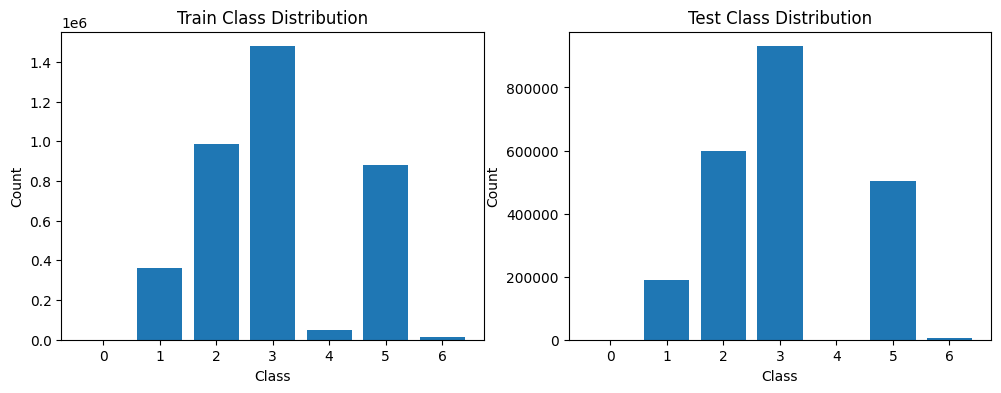

In [8]:
def calculate_class_distribution(dataset):
    
    class_counts = [0] * 7

    for image, mask in dataset:

        flat_mask = np.array(mask).flatten()
        
        for class_idx in range(7):
            class_counts[class_idx] += np.sum(flat_mask == class_idx)
    
    return class_counts     
    

train_class_distribution = calculate_class_distribution(train_dataset)
test_class_distribution = calculate_class_distribution(test_dataset)

# plot the class distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.bar(range(7), train_class_distribution)
plt.title("Train Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.subplot(1, 2, 2)
plt.bar(range(7), test_class_distribution)
plt.title("Test Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

We can see that the classes are not equally distrubuted, class 3 is the most common, while there is bairly any class 4 <br><br>
Note: class 0 is supposed to be void according to the readme, but i am not sure what that is as it is not used in any of the mask and does not have a color code

# Model and Helper functions

In [9]:
def train_one_epoch(model, optimizer, criterion, train_loader):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(train_loader)

def test(model, criterion, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            test_loss += loss.item()
    return test_loss / len(test_loader)
            
def show_img(image):
    min_img = image.min()
    max_img = image.max()
    showimg = ((image-min_img)/(max_img-min_img)).permute(1, 2, 0)
    return showimg
       
def visualize_segmentation(model, test_loader, device):
    # visualize some images
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    output = model(images)
    output = output.permute(0, 2, 3, 1)
    output = torch.sigmoid(output)
    output = torch.argmax(output, dim=3)
    output = output.cpu().numpy()
    labels = labels.cpu().numpy()

    # Increase the plot size
    plt.figure(figsize=(12, 6))

    for i in range(5):
        plt.subplot(3, 5, i + 1)
        plt.imshow(show_img(images[i]).cpu().numpy())
        plt.title('Input Image')
        plt.axis('off')  # Remove the axis
        plt.subplot(3, 5, i + 6)
        plt.imshow(colorcode_segmentation(output[i],freiburg_color_code, freiburg_ids_to_class))
        plt.title('Predicted Mask')
        plt.axis('off')  # Remove the axis
        plt.subplot(3, 5, i + 11)
        plt.imshow(colorcode_segmentation(labels[i],freiburg_color_code, freiburg_ids_to_class))
        plt.title('Ground Truth')
        plt.axis('off')  # Remove the axis
    plt.show()


In [10]:

class DownLayer(nn.Module):
    """
    Abstraction of a down layer in a CNN. A down layer consists of a convolutional layer followed by a ReLU activation function.
    """
    def __init__(self, in_channels, out_channels):
        super(DownLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        return x
    
class UpLayerTranspose(nn.Module):
    """
    Abstraction of a up layer in a CNN. A up layer consists of a transposed convolutional layer followed by a ReLU activation function.
    """
    def __init__(self, in_channels, out_channels):
        super(UpLayerTranspose, self).__init__()
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, padding=1, output_padding=1, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        return x



In [11]:

class UnetCNN(nn.Module):
    def __init__(self, input_dim=3, hidden_dims=[32, 64, 128], output_dim=7):
        super(UnetCNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        
        # Encoder layers
        self.encoder_hidden_layers = nn.ModuleList()
        in_dim  = input_dim
        for i in range(0, len(hidden_dims)):
            self.encoder_hidden_layers.append(DownLayer(in_dim, hidden_dims[i]))
            in_dim = hidden_dims[i]
        
        # Decoder layers
        self.decoder_hidden_layers = nn.ModuleList()
        in_dim = hidden_dims[-1]
        for i in range(len(hidden_dims)-1, -1, -1):
            self.decoder_hidden_layers.append(UpLayerTranspose(in_dim * 2, hidden_dims[i - 1]))
            in_dim = hidden_dims[i - 1]
        self.output_layer = nn.Conv2d(in_dim, output_dim, kernel_size=3, padding=1)

    def forward(self, x):
        # list to store the output of the encoder layers
        output_encoder = []
        # forward pass trough the encoder
        for hidden_layer in self.encoder_hidden_layers:
            x = hidden_layer(x)
            x = F.relu(x)
            # store the output of the encoder layers
            output_encoder.append(x)

        # forward pass trough the decoder
        for i, hidden_layer in enumerate(self.decoder_hidden_layers):
            # concatenate the output of the encoder layers
            x = torch.cat([x, output_encoder[-i - 1]], dim=1)
            x = hidden_layer(x)
            x = F.relu(x)
        x = self.output_layer(x)
        return x
    
# test if our model works for segmentation by keeping the original input dimensions
model = UnetCNN()
test_image = torch.rand(1, 3, 128, 128)
output = model(test_image)
print(f"Input shape: {test_image.shape}, output shape: {output.shape}")
assert test_image.shape[2:] == output.shape[2:], "Input and output dimensions should be the same"


Input shape: torch.Size([1, 3, 128, 128]), output shape: torch.Size([1, 7, 128, 128])


# Training on rgb

In [70]:
# create the network
model = UnetCNN(hidden_dims=[16, 32, 64, 128])
count_parameters(model)
# create the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# create the loss function
criterion = nn.CrossEntropyLoss()
# set the device
device = torch.device("cuda" if use_cuda else "cpu")
model.to(device)

Model has 0.34M parameters


UnetCNN(
  (encoder_hidden_layers): ModuleList(
    (0): DownLayer(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): DownLayer(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (2): DownLayer(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (3): DownLayer(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (decoder_hidden_layers): ModuleList(
    (0): UpLayerTranspose(
      (conv): ConvTranspose2d(256, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    )
    (1): UpLayerTranspose(
      (conv): ConvTranspose2d(128, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    )
    (2): UpLayerTranspose(
      (conv): ConvTranspose2d(64, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    )
    (3): UpLayerTranspose(
      (conv): ConvTra

In [71]:
EPOCHS = 20
train_losses = []
test_losses = []
start_time = time.time()
pbar = tqdm(range(EPOCHS))
for epoch in pbar:
    train_loss = train_one_epoch(model, optimizer, criterion, train_loader)
    test_loss = test(model, criterion, test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    pbar.set_description(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
end_time = time.time()
print(f"Training time in minutes: {(end_time - start_time) / 60:.2f} on {device} for {EPOCHS} epochs")

Epoch 20, Train Loss: 0.3037, Test Loss: 0.3032: 100%|██████████| 20/20 [05:48<00:00, 17.43s/it]

Training time in minutes: 5.81 on cpu for 20 epochs


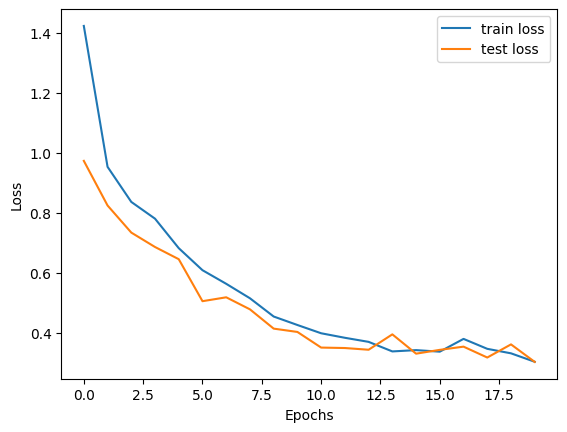

In [72]:
# plot the train and test losses
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
def intersection(prediction, target, relevant_class=1):
    """
    Calculate the intersection between the prediction and the target for a specific class
    Args:
    - prediction: the predicted segmentation mask of shape (N, H, W) where N is the batch size and H, W are the height and width of the mask
    - target: the target segmentation mask of shape (N, H, W) where N is the batch size and H, W are the height and width of the mask
    - relevant_class: the class index that we are interested in calculating the intersection for
    """
    # Your solution goes here
    # calculate the intersection
    
    pred_mask = (prediction == relevant_class)
    target_mask = (target == relevant_class)
    
    
    intersection = torch.Tensor.sum(pred_mask & target_mask)

    return intersection

def union(prediction, target, relevant_class=1):
    """
    Calculate the union between the prediction and the target for a specific class
    Args:
    - prediction: the predicted segmentation mask of shape (N, H, W) where N is the batch size and H, W are the height and width of the mask
    - target: the target segmentation mask of shape (N, H, W) where N is the batch size and H, W are the height and width of the mask
    - relevant_class: the class index that we are interested in calculating the union for
    """
    # Your solution goes here
    # calculate the union
    pred_mask = (prediction == relevant_class)
    target_mask = (target == relevant_class)
    
    union = torch.Tensor.sum(pred_mask | target_mask)
    return union


def iou(prediction, target):
    """
    Calculate the mean intersection over union for the prediction and target
    Args:
    - prediction: the predicted segmentation mask of shape (N, H, W) where N is the batch size and H, W are the height and width of the mask
    - target: the target segmentation mask of shape (N, H, W) where N is the batch size and H, W are the height and width of the mask
    """
    # calculate the number of classes
    class_indices = torch.unique(target)
    # initialize the list to store the iou for each class
    iou_per_class = []
    # iterate over each class
    for i in class_indices:
        # calculate the intersection for the class
        inter = intersection(prediction, target, i)
        # calculate the union for the class
        uni = union(prediction, target, i)
        # calculate the iou for the class
        iou = inter / uni
        iou_per_class.append(iou)
    # calculate the mean iou
    
    return torch.mean(torch.Tensor(iou_per_class)).item()    
    

In [13]:
def accuracy(output, target):
    """
    Function to calculate the accuracy given the output and target
    Args:
    - output: the predicted segmentation mask of shape (N, H, W) where N is the batch size and H, W are the height and width of the mask
    - target: the target segmentation mask of shape (N, H, W) where N is the batch size and H, W are the height and width of the mask
    """
    accuracy = torch.sum(output == target) / (output.shape[0] * output.shape[1] * output.shape[2])
    return accuracy.item()
    

def validate(model, test_loader, device):
    model.eval()
    accuracy_list = []
    iou_list = []
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            # argmax to get the class index
            output = torch.argmax(output, dim=1)
            accuracy_list.append(accuracy(output, labels))
            iou_list.append(iou(output, labels))
    mean_accuracy = sum(accuracy_list) / len(test_loader)
    mean_iou = sum(iou_list) / len(test_loader)
    return mean_accuracy, mean_iou


In [88]:
m_accuracy, m_iou = validate(model, test_loader, device)
print(f'Accuracy: {m_accuracy}, IoU: {m_iou}')

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:04<00:00,  2.46it/s]

Accuracy: 0.8992292582988739, IoU: 0.6448646932840347


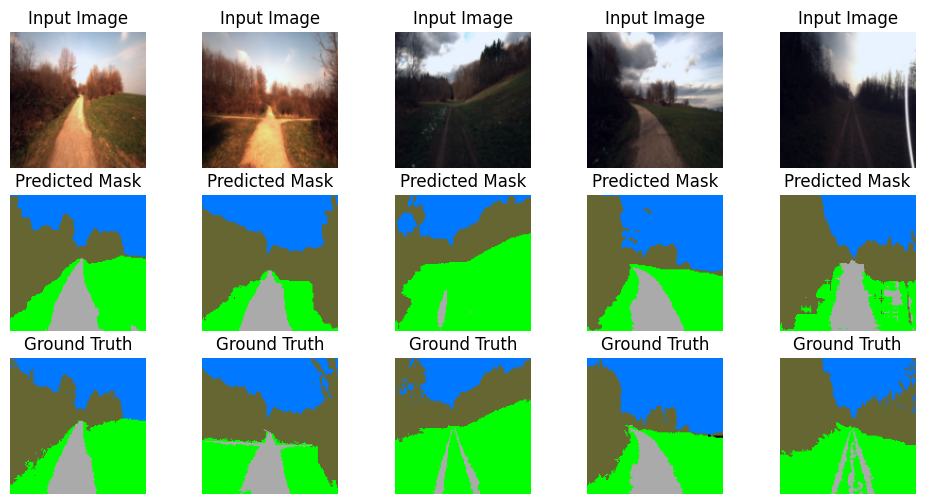

In [81]:
visualize_segmentation(model, test_loader, device)

Over all the Accuaracy is quite impressive for 5 minutes of trainig, and the loss for both train and test is decreasing with more epochs, so we might benefit from more epochs. <br>
The detection images are a bit fussy and there are some artifaces here and there, but over all the predicted masks are quite impressive and mostly show the correct categories for the correct areas, althouogh some of the finer details are lost

The test data for some reason does not have the trees masked, so we can test again the train data to see if the model is able to detect trees

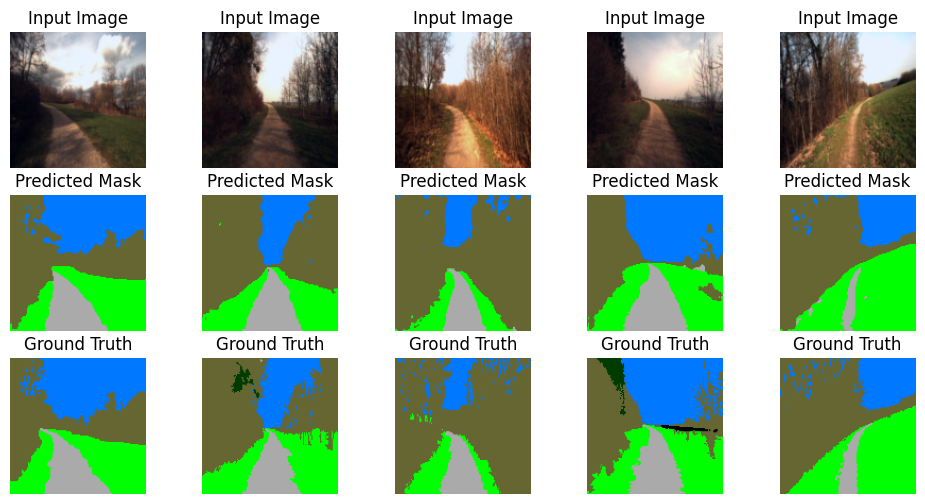

In [86]:
visualize_segmentation(model, train_loader, device)

We can see that it struggles to identefy trees from normal vegitation 

# More Modaleties

We can use diffrent image sets for training such as 

In [17]:
BATCH_SIZE = 12
# create the dataset
train_dataset = FreiburgDataset('data/Freiburg_Forest_Dataset', image_transform, label_transform, is_train=True, limit=None, img_type="depth_color")
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

0it [00:00, ?it/s]


ValueError: num_samples should be a positive integer value, but got num_samples=0